In [1]:
from os import chdir
chdir('/Users/lananhnguyen/Desktop/thesis/thesis_code')
import main.packages.mine_generic as mine_g
import main.packages.mine_specific as mine_s


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 


from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import xgboost as xgb
import optuna
import json
from sklearn.preprocessing import StandardScaler


In [2]:
optuna.logging.set_verbosity(optuna.logging.WARNING)


In [3]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [4]:
# Forecast:
def generate_forecast(X, y, N, T, h, hyperparam, verbose=1): # from common function
    """
    Generate recursive forecast
    """
    print(f"Horizon: {h}")
    print("------------------------")
    y_pred_series = []
    for i in range(0, T):  # T+1-h
        X_train = X.iloc[: N+i, :]
        y_train = y.iloc[h: N+i+h, :]

        X_test = X.iloc[N+i : N+i+1, :] 
        y_test = y.iloc[N+i+h : N+i+h+1, :]  

        if X_test.index[-1] > X.index[-1]-pd.DateOffset(months=h):
            break

        # Forecast:
        y_pred = mine_s.xgb_pred(X_train, X_test, y_train, y_test, hyperparam)

        if verbose == 1:
            print(f"Training period - features: {X_train.index[0]} to {X_train.index[-1]}")
            print(f"Training period - target : {y_train.index[0]} to {y_train.index[-1]}")
            print(f"Test period - features: {X_test.index}")
            print(f"Test period - target : {y_test.index}")
            print(f"Forecast: {y_pred}")
            print("-------------------------------------------------------")

        y_pred_series.append(y_pred[0])
    return y_pred_series

In [5]:
hicp_all_path = 'data/preprocessed/hicp_yoy.csv'
hicp_class_path = 'data/HICP_COICOP10s.xlsx'
model = 'xgb'
date_range = pd.date_range(start=mine_g.train_test_split_date + pd.DateOffset(months=1), end=mine_g.max_X_date, freq='M')


# Food:

In [6]:
category = 'Food'
cat_short = 'food'
hicp_cat_path = f'data/preprocessed/{cat_short}_yoy_infl.csv'
save_cat_file_path = f'data/forecast_results/{cat_short}_forecast.csv'

HICP_monthly, HICP_class, HICP_cat = mine_g.import_data_all(hicp_all_path=hicp_all_path,
                                                     hicp_class_path=hicp_class_path,
                                                     hicp_cat_path=hicp_cat_path)

cat_df = mine_g.split_into_category(category=category,
                             HICP_class=HICP_class,
                             HICP_monthly=HICP_monthly)
food_cat_prediction = pd.DataFrame(index=date_range)

Number of items in Food group:  180


/Users/lananhnguyen/Desktop/thesis/thesis_code/main/packages/mine_generic.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df.fillna(0, inplace=True)


## h = 1

In [7]:
h = 1
#cat_df = pd.merge(cat_df, HICP_cat, how='inner', left_index=True, right_index=True)
X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)



Horizon: 1
Training predictor period: 1997-01-31 00:00:00 to 2015-11-30 00:00:00
Training dependent variable period: 1997-02-28 00:00:00 to 2015-12-31 00:00:00


In [8]:

best_param = mine_s.hyperparam_tuning_optuna(mine_s.objective_xgb, X_cat_train, y_cat_train)

# save best_param:

with open(f'models/{model}_{cat_short}_h_{h}_hyperparam.json', 'w') as json_file:
    json.dump(best_param, json_file)


Number of finished trials: 1000


In [9]:
# Forecast:

N, T = len(X_cat_train), len(X_cat_test)
y_pred = generate_forecast(X = cat_df, y = HICP_cat, N = N, T = T, h = h, hyperparam=best_param, verbose=0)
food_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = y_pred


Horizon: 1
------------------------


In [12]:

yoy_real = pd.read_csv(f"data/preprocessed/{cat_short}_yoy_infl.csv", parse_dates=True, index_col='date')
yoy_real_test = yoy_real[(yoy_real.index > mine_g.train_test_split_date) & (yoy_real.index <= mine_g.max_X_date)]


print(mean_absolute_error(yoy_real_test, y_pred))
print(np.sqrt(mean_squared_error(yoy_real_test, y_pred)))

1.0283657102667991
1.862162850883055


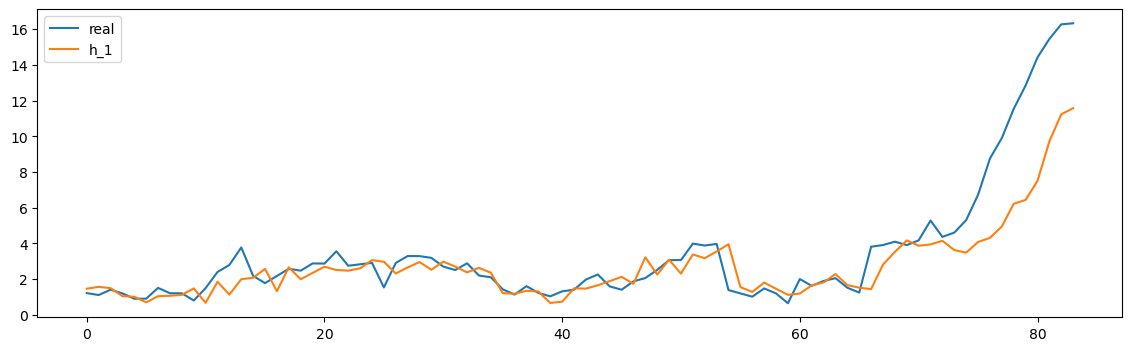

In [11]:
plt.figure(figsize=(14, 4))
plt.plot(yoy_real_test.reset_index(drop=True), label = "real")

plt.plot(y_pred, label = "h_1")
plt.legend()
plt.show()

## h = 2

In [9]:
h = 2
X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

best_param = mine_s.hyperparam_tuning_optuna(mine_s.objective_xgb, X_cat_train, y_cat_train)

# save best_param:
with open(f'models/{model}_{cat_short}_h_{h}_hyperparam.json', 'w') as json_file:
    json.dump(best_param, json_file)


Horizon: 2
Training predictor period: 1997-01-31 00:00:00 to 2015-10-31 00:00:00
Training dependent variable period: 1997-03-31 00:00:00 to 2015-12-31 00:00:00
Number of finished trials: 1000


In [ ]:


N, T = len(X_cat_train), len(X_cat_test)

y_pred = generate_forecast(X = cat_df, y = HICP_cat, N = N, T = T, h = h, hyperparam=best_param)
food_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = y_pred


## h = 3

In [10]:
h = 3
X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

best_param = mine_s.hyperparam_tuning_optuna(mine_s.objective_xgb, X_cat_train, y_cat_train)

# save best_param:
with open(f'models/{model}_{cat_short}_h_{h}_hyperparam.json', 'w') as json_file:
    json.dump(best_param, json_file)


Horizon: 3
Training predictor period: 1997-01-31 00:00:00 to 2015-09-30 00:00:00
Training dependent variable period: 1997-04-30 00:00:00 to 2015-12-31 00:00:00
Number of finished trials: 1000


In [ ]:

N, T = len(X_cat_train), len(X_cat_test)

y_pred = generate_forecast(X = cat_df, y = HICP_cat, N = N, T = T, h = h, hyperparam=best_param)
food_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = y_pred


In [13]:
food_cat_prediction

,xgb_food_h_1,xgb_food_h_2,xgb_food_h_3
2016-01-31,1.456735,1.684200,1.327366
2016-02-29,1.561387,0.897192,0.887290
2016-03-31,1.489828,1.047011,0.772796
2016-04-30,1.040370,1.194955,1.232249
2016-05-31,1.005898,1.296793,1.464055
...,...,...,...
2022-08-31,6.435944,3.928889,4.929259
2022-09-30,7.501304,6.534640,4.795111
2022-10-31,9.717562,6.745116,7.938904
2022-11-30,11.234087,9.469630,8.797004


In [14]:
mine_g.save_forecast(forecast_result_df=food_cat_prediction.reset_index(drop=True), cat_file_path=save_cat_file_path, category=cat_short)

------------------

# Energy:

In [11]:
category = 'Energy'
cat_short = 'energy'
hicp_cat_path = f'data/preprocessed/{cat_short}_yoy_infl.csv'
save_cat_file_path = f'data/forecast_results/{cat_short}_forecast.csv'

HICP_monthly, HICP_class, HICP_cat = mine_g.import_data_all(hicp_all_path=hicp_all_path,
                                                     hicp_class_path=hicp_class_path,
                                                     hicp_cat_path=hicp_cat_path)

cat_df = mine_g.split_into_category(category=category,
                             HICP_class=HICP_class,
                             HICP_monthly=HICP_monthly)
energy_cat_prediction = pd.DataFrame(index=date_range)

Number of items in Energy group:  14


/Users/lananhnguyen/Desktop/thesis/thesis_code/main/packages/mine_generic.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df.fillna(0, inplace=True)


In [12]:
for h in [1, 2, 3]:
    X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

    best_param = mine_s.hyperparam_tuning_optuna(mine_s.objective_xgb, X_cat_train, y_cat_train)

    # save best_param:
    with open(f'models/{model}_{cat_short}_h_{h}_hyperparam.json', 'w') as json_file:
        json.dump(best_param, json_file)

    N, T = len(X_cat_train), len(X_cat_test)

    y_pred = generate_forecast(X = cat_df, y = HICP_cat, N = N, T = T, h = h, hyperparam=best_param, verbose=0)
    energy_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = y_pred


Horizon: 1
Training predictor period: 1997-01-31 00:00:00 to 2015-11-30 00:00:00
Training dependent variable period: 1997-02-28 00:00:00 to 2015-12-31 00:00:00
Number of finished trials: 1000
Horizon: 1
------------------------
Horizon: 2
Training predictor period: 1997-01-31 00:00:00 to 2015-10-31 00:00:00
Training dependent variable period: 1997-03-31 00:00:00 to 2015-12-31 00:00:00
Number of finished trials: 1000
Horizon: 2
------------------------
Horizon: 3
Training predictor period: 1997-01-31 00:00:00 to 2015-09-30 00:00:00
Training dependent variable period: 1997-04-30 00:00:00 to 2015-12-31 00:00:00
Number of finished trials: 1000
Horizon: 3
------------------------


In [13]:
mine_g.save_forecast(forecast_result_df=energy_cat_prediction.reset_index(drop=True), cat_file_path=save_cat_file_path, category=cat_short)

In [15]:
energy_cat_prediction

,xgb_energy_h_1,xgb_energy_h_2,xgb_energy_h_3
2016-01-31,-6.033554,-5.989275,-6.273275
2016-02-29,-4.435302,-5.777793,-5.934877
2016-03-31,-7.753590,-5.052814,-6.941639
2016-04-30,-7.600391,-6.802638,-6.574847
2016-05-31,-8.201786,-6.818075,-6.767157
...,...,...,...
2022-08-31,29.527771,29.998022,27.126225
2022-09-30,31.542278,31.460135,27.638664
2022-10-31,33.063725,31.090862,25.422089
2022-11-30,35.037140,34.874874,30.271833


## NEIG:

In [16]:
cat_short = 'neig'
category = 'Non-energy industrial goods (NEIG)'
hicp_cat_path = f'data/preprocessed/{cat_short}_yoy_infl.csv'
save_cat_file_path = f'data/forecast_results/{cat_short}_forecast.csv'

HICP_monthly, HICP_class, HICP_cat = mine_g.import_data_all(hicp_all_path=hicp_all_path,
                                                     hicp_class_path=hicp_class_path,
                                                     hicp_cat_path=hicp_cat_path)

cat_df = mine_g.split_into_category(category=category,
                             HICP_class=HICP_class,
                             HICP_monthly=HICP_monthly)
neig_cat_prediction = pd.DataFrame(index=date_range)

Number of items in Non-energy industrial goods (NEIG) group:  302


/Users/lananhnguyen/Desktop/thesis/thesis_code/main/packages/mine_generic.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df.fillna(0, inplace=True)


In [17]:
for h in [1, 2, 3]:
    X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

    best_param = mine_s.hyperparam_tuning_optuna(mine_s.objective_xgb, X_cat_train, y_cat_train)

    # save best_param:
    with open(f'models/{model}_{cat_short}_h_{h}_hyperparam.json', 'w') as json_file:
        json.dump(best_param, json_file)

    N, T = len(X_cat_train), len(X_cat_test)

    y_pred = generate_forecast(X = cat_df, y = HICP_cat, N = N, T = T, h = h, hyperparam=best_param, verbose=0)
    neig_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = y_pred


Horizon: 1
Training predictor period: 1997-01-31 00:00:00 to 2015-11-30 00:00:00
Training dependent variable period: 1997-02-28 00:00:00 to 2015-12-31 00:00:00
Number of finished trials: 1000
Horizon: 1
------------------------
Horizon: 2
Training predictor period: 1997-01-31 00:00:00 to 2015-10-31 00:00:00
Training dependent variable period: 1997-03-31 00:00:00 to 2015-12-31 00:00:00
Number of finished trials: 1000
Horizon: 2
------------------------
Horizon: 3
Training predictor period: 1997-01-31 00:00:00 to 2015-09-30 00:00:00
Training dependent variable period: 1997-04-30 00:00:00 to 2015-12-31 00:00:00
Number of finished trials: 1000
Horizon: 3
------------------------


In [21]:
mine_g.save_forecast(forecast_result_df=neig_cat_prediction.reset_index(drop=True), cat_file_path=save_cat_file_path, category=cat_short)

# Services:

In [19]:
cat_short = 'services'
category = 'Services'
hicp_cat_path = f'data/preprocessed/{cat_short}_yoy_infl.csv'
save_cat_file_path = f'data/forecast_results/{cat_short}_forecast.csv'

HICP_monthly, HICP_class, HICP_cat = mine_g.import_data_all(hicp_all_path=hicp_all_path,
                                                     hicp_class_path=hicp_class_path,
                                                     hicp_cat_path=hicp_cat_path)

cat_df = mine_g.split_into_category(category=category,
                             HICP_class=HICP_class,
                             HICP_monthly=HICP_monthly)
services_cat_prediction = pd.DataFrame(index=date_range)

Number of items in Services group:  148


/Users/lananhnguyen/Desktop/thesis/thesis_code/main/packages/mine_generic.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df.fillna(0, inplace=True)


In [20]:
for h in [1, 2, 3]:
    X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

    best_param = mine_s.hyperparam_tuning_optuna(mine_s.objective_xgb, X_cat_train, y_cat_train)

    # save best_param:
    with open(f'models/{model}_{cat_short}_h_{h}_hyperparam.json', 'w') as json_file:
        json.dump(best_param, json_file)

    N, T = len(X_cat_train), len(X_cat_test)

    y_pred = generate_forecast(X = cat_df, y = HICP_cat, N = N, T = T, h = h, hyperparam=best_param, verbose=0)
    services_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = y_pred


Horizon: 1
Training predictor period: 1997-01-31 00:00:00 to 2015-11-30 00:00:00
Training dependent variable period: 1997-02-28 00:00:00 to 2015-12-31 00:00:00
Number of finished trials: 1000
Horizon: 1
------------------------
Horizon: 2
Training predictor period: 1997-01-31 00:00:00 to 2015-10-31 00:00:00
Training dependent variable period: 1997-03-31 00:00:00 to 2015-12-31 00:00:00
Number of finished trials: 1000
Horizon: 2
------------------------
Horizon: 3
Training predictor period: 1997-01-31 00:00:00 to 2015-09-30 00:00:00
Training dependent variable period: 1997-04-30 00:00:00 to 2015-12-31 00:00:00
Number of finished trials: 1000
Horizon: 3
------------------------


In [26]:
mine_g.save_forecast(forecast_result_df=services_cat_prediction.reset_index(drop=True), cat_file_path=save_cat_file_path, category=cat_short)